In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from mdp_description import MDPDescription
from RandomMDP.simplified_new_mdp_description import SimplifiedNewMDPDescription
from forked_riverswim import ForkedRiverSwim
from scipy.special import rel_entr
from utils import project_omega,compute_stationary_distribution, unit_vector, angle_between, gram_schmidt
import matplotlib.ticker as mticker
from riverswim import RiverSwim
from scipy.stats import bootstrap
from scipy.stats import t

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

def compute_ce_median(values, c=0.95):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=c).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return res[:, 0], res[:, 1]


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

In [2]:
N_SIMS = 300
NS = 5
NEPS = 10**np.geomspace(-2, np.log10(0.99), 100)
NTHETAS = [0]
NA = 4
discount_factor = 0.99
np.random.seed(2)

In [75]:
random_res_U_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_U_gen_proj = np.zeros((N_SIMS,len(NEPS)))
random_res_U_nc = np.zeros(N_SIMS)
random_res_TV_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_gen_proj = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_nc = np.zeros( N_SIMS)
random_res_U_C = np.zeros(N_SIMS)


for sim in tqdm(range(N_SIMS)):
    while True:
        try:
            P0 = np.ones((NS, NA, NS)) / NS
            P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            mdp = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            random_res_U_C[sim] = mdp.evaluate_allocation(omega_nav_constr)      
            
            mdp_theta = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            random_res_U_nc[sim] = mdp.evaluate_allocation(omega_nav_constr_theta)
            random_res_TV_nc[sim] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
                random_res_TV_gen_stationary[sim, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                random_res_U_gen_stationary[sim, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_proj_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                omega_gen_proj_eps = project_omega(omega_gen_proj_eps, P, force_policy=False)
                random_res_TV_gen_proj[sim, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                random_res_U_gen_proj[sim, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue



with open('./data/data_generative_comparison_nc_randommdp_2.pkl', 'wb') as f:
    pickle.dump({'random_res_U_gen_stationary': random_res_U_gen_stationary, 'random_res_TV_gen_stationary': random_res_TV_gen_stationary,
                 'random_res_U_gen_proj': random_res_U_gen_proj, 'random_res_TV_gen_proj': random_res_TV_gen_proj,
                 'random_res_U_nc': random_res_U_nc, 'random_res_TV_nc': random_res_TV_nc,
                 'random_res_U_C': random_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

 84%|████████▎ | 251/300 [39:55<07:42,  9.44s/it]/home/alessio/anaconda3/envs/maze-exploration/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 300/300 [47:46<00:00,  9.55s/it]


In [3]:
riverswim_res_U_gen_stationary = np.zeros(len(NEPS))
riverswim_res_U_gen_proj = np.zeros(len(NEPS))
riverswim_res_U_nc =0
riverswim_res_TV_gen_stationary = np.zeros(len(NEPS))
riverswim_res_TV_gen_proj = np.zeros(len(NEPS))
riverswim_res_TV_nc = 0
riverswim_res_U_C = 0

NS_RIVER = 20
env = RiverSwim(num_states=NS_RIVER)

while True:
    try:
        P0 = np.ones((NS_RIVER, 2, NS_RIVER)) / NS_RIVER
        P = env.transitions
        R = env.rewards
        mdp = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        mdp_theta = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
        
        omega_gen_theta = mdp_theta.compute_allocation()[0]
        omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
        riverswim_res_U_nc = mdp.evaluate_allocation(omega_nav_constr_theta)
        riverswim_res_TV_nc = TV(omega_nav_constr_theta, omega_nav_constr)
        
        # Forced projected generative
        for id_eps, eps in enumerate(NEPS):
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
            omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
            riverswim_res_TV_gen_stationary[id_eps] = TV(omega_gen_stationary, omega_nav_constr)
            riverswim_res_U_gen_stationary[id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

            # Unforced projected generative
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
            omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
            riverswim_res_TV_gen_proj[id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
            riverswim_res_U_gen_proj[id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_riverswim_2.pkl', 'wb') as f:
    pickle.dump({'riverswim_res_U_gen_stationary': riverswim_res_U_gen_stationary, 'riverswim_res_TV_gen_stationary': riverswim_res_TV_gen_stationary,
                 'riverswim_res_U_gen_proj': riverswim_res_U_gen_proj, 'riverswim_res_TV_gen_proj': riverswim_res_TV_gen_proj,
                 'riverswim_res_U_nc': riverswim_res_U_nc, 'riverswim_res_TV_nc': riverswim_res_TV_nc,
                 'riverswim_res_U_C': riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
forked_riverswim_res_U_gen_stationary = np.zeros(len(NEPS))
forked_riverswim_res_U_gen_proj = np.zeros(len(NEPS))
forked_riverswim_res_U_nc =0
forked_riverswim_res_TV_gen_stationary = np.zeros(len(NEPS))
forked_riverswim_res_TV_gen_proj = np.zeros(len(NEPS))
forked_riverswim_res_TV_nc = 0
forked_riverswim_res_U_C = 0

env = ForkedRiverSwim(10)

ns, na = env.transitions.shape[0], env.transitions.shape[1]

while True:
    try:
        P0 = np.ones((ns, na, ns)) / ns
        P = env.transitions
        R = env.rewards
        mdp = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        forked_riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        mdp_theta = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
        
        omega_gen_theta = mdp_theta.compute_allocation()[0]
        omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
        forked_riverswim_res_U_nc = mdp.evaluate_allocation(omega_nav_constr_theta)
        forked_riverswim_res_TV_nc = TV(omega_nav_constr_theta, omega_nav_constr)
        
        # Forced projected generative
        for id_eps, eps in enumerate(NEPS):
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
            omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
            forked_riverswim_res_TV_gen_stationary[id_eps] = TV(omega_gen_stationary, omega_nav_constr)
            forked_riverswim_res_U_gen_stationary[id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

            # Unforced projected generative
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
            omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
            forked_riverswim_res_TV_gen_proj[id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
            forked_riverswim_res_U_gen_proj[id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_forked_riverswim_2.pkl', 'wb') as f:
    pickle.dump({'forked_riverswim_res_U_gen_stationary': forked_riverswim_res_U_gen_stationary, 'forked_riverswim_res_TV_gen_stationary': forked_riverswim_res_TV_gen_stationary,
                 'forked_riverswim_res_U_gen_proj': forked_riverswim_res_U_gen_proj, 'forked_riverswim_res_TV_gen_proj': forked_riverswim_res_TV_gen_proj,
                 'forked_riverswim_res_U_nc': forked_riverswim_res_U_nc, 'forked_riverswim_res_TV_nc': forked_riverswim_res_TV_nc,
                 'forked_riverswim_res_U_C': forked_riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('./data/data_generative_comparison_nc_randommdp_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

random_res_U_gen_stationary = data['random_res_U_gen_stationary']
random_res_U_gen_proj = data['random_res_U_gen_proj']
random_res_U_nc = data['random_res_U_nc']
random_res_TV_gen_stationary = data['random_res_TV_gen_stationary']
random_res_TV_gen_proj = data['random_res_TV_gen_proj']
random_res_TV_nc = data['random_res_TV_nc']
random_res_U_C = data['random_res_U_C']


with open('./data/data_generative_comparison_nc_riverswim_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

riverswim_res_U_gen_stationary = data['riverswim_res_U_gen_stationary']
riverswim_res_U_gen_proj = data['riverswim_res_U_gen_proj']
riverswim_res_U_nc = data['riverswim_res_U_nc']
riverswim_res_TV_gen_stationary = data['riverswim_res_TV_gen_stationary']
riverswim_res_TV_gen_proj = data['riverswim_res_TV_gen_proj']
riverswim_res_TV_nc = data['riverswim_res_TV_nc']
riverswim_res_U_C = data['riverswim_res_U_C']


with open('./data/data_generative_comparison_nc_forked_riverswim_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

forked_riverswim_res_U_gen_stationary = data['forked_riverswim_res_U_gen_stationary']
forked_riverswim_res_U_gen_proj = data['forked_riverswim_res_U_gen_proj']
forked_riverswim_res_U_nc = data['forked_riverswim_res_U_nc']
forked_riverswim_res_TV_gen_stationary = data['forked_riverswim_res_TV_gen_stationary']
forked_riverswim_res_TV_gen_proj = data['forked_riverswim_res_TV_gen_proj']
forked_riverswim_res_TV_nc = data['forked_riverswim_res_TV_nc']
forked_riverswim_res_U_C = data['forked_riverswim_res_U_C']

[]

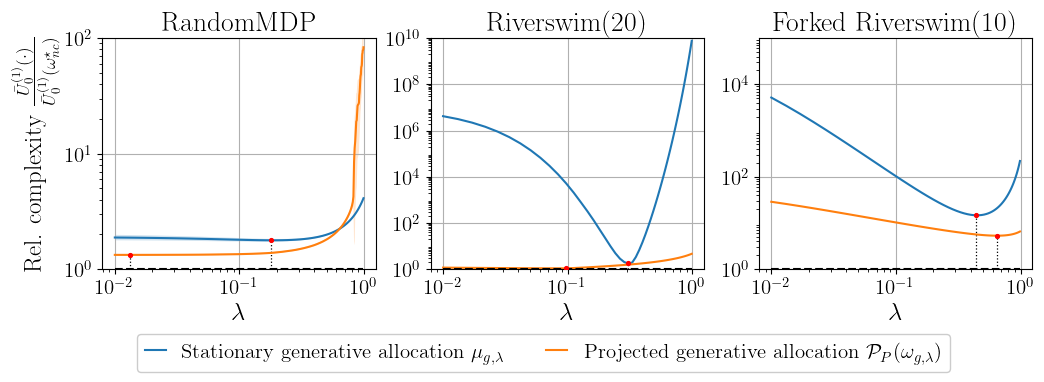

In [170]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}
#### Random MDP
mu, ce = CE(((random_res_U_gen_stationary ) / random_res_U_C[...,np.newaxis]))
ax[0].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu, ce = CE(((random_res_U_gen_proj ) / random_res_U_C[...,np.newaxis]))
ax[0].plot(NEPS, mu, label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')
ax[0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

#### RiverSwim
mu = (riverswim_res_U_gen_stationary)/ riverswim_res_U_C
ax[1].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu = (riverswim_res_U_gen_proj)/ riverswim_res_U_C
ax[1].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')#, linestyle=linestyles[na], marker=markers[ns])
ax[1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


## Forked riverswim
mu = (forked_riverswim_res_U_gen_stationary)/ forked_riverswim_res_U_C
ax[2].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


mu = (forked_riverswim_res_U_gen_proj)/ forked_riverswim_res_U_C
ax[2].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')#, linestyle=linestyles[na], marker=markers[ns])
ax[2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

ax[0].set_title('RandomMDP')
ax[1].set_title('Riverswim(20)')
ax[2].set_title('Forked Riverswim(10)')

#ax[2].text(1.5e-2, 1.4, r'Optimal sampling', fontsize=14)


for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].grid()
    ax[i].yaxis.set_major_locator(mticker.LogLocator(numticks=6))
    ax[i].yaxis.set_minor_locator(mticker.LogLocator(numticks=12, subs="auto"))
    ax[i].plot(NEPS, 1*np.ones_like(NEPS), 'k--')

ax[0].set_ylim(1, 10**2)
ax[1].set_ylim(1, 10**10)
ax[2].set_ylim(1, 10**5)

ax[0].set_ylabel(r'Rel. complexity $\frac{\bar U_0^{(1)}(\cdot)}{\bar U_0^{(1)}(\omega_{nc}^\star)}$')
legend = ax[1].legend(ncols=2,handlelength=1,framealpha=1, bbox_to_anchor=(1.9, -0.28), borderaxespad=0)

plt.savefig('./figures/comparison_sample_complexity_projected.pdf', bbox_inches="tight")
plt.plot()


[]

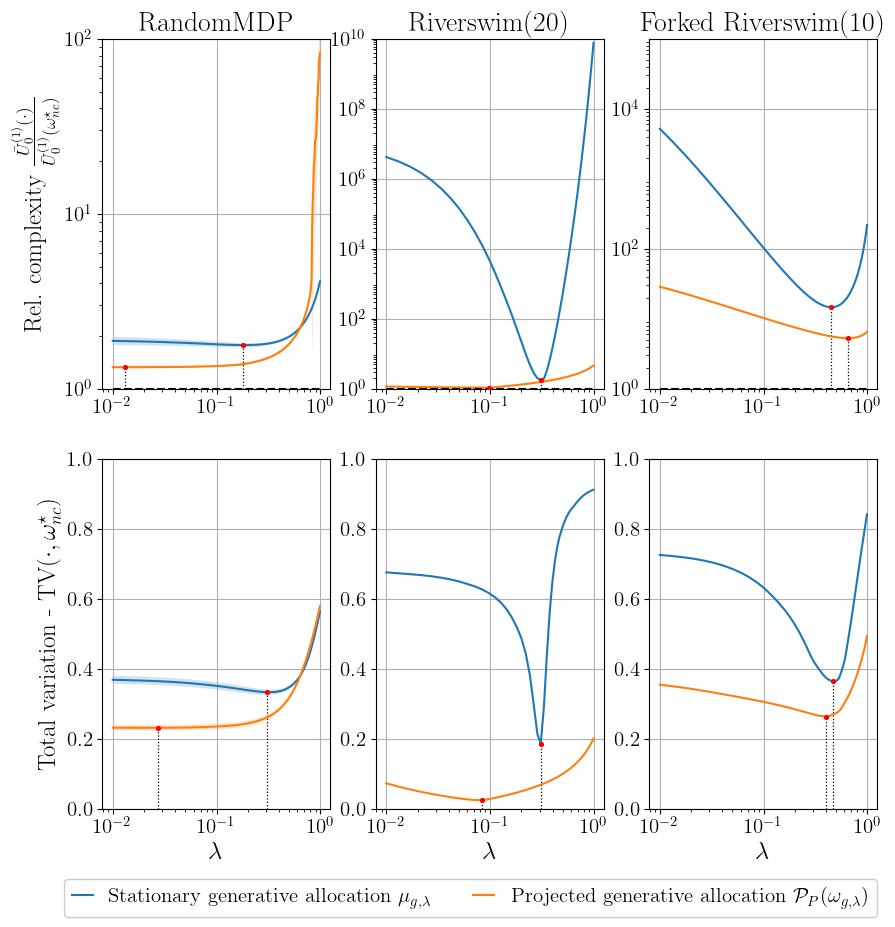

In [190]:
fig, ax = plt.subplots(2,3, figsize=(10,10))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}
#### Random MDP
mu, ce = CE(((random_res_U_gen_stationary ) / random_res_U_C[...,np.newaxis]))
ax[0,0].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[0,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[0,0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu, ce = CE(((random_res_U_gen_proj ) / random_res_U_C[...,np.newaxis]))
ax[0,0].plot(NEPS, mu, label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')
ax[0,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[0,0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu, ce = CE(random_res_TV_gen_stationary)
ax[1,0].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[1,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[1,0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


mu, ce = CE(random_res_TV_gen_proj)
ax[1,0].plot(NEPS, mu, label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')
ax[1,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[1,0].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,0].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

#### RiverSwim
mu = (riverswim_res_U_gen_stationary)/ riverswim_res_U_C
ax[0,1].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[0,1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu = (riverswim_res_U_gen_proj)/ riverswim_res_U_C
ax[0,1].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


mu = riverswim_res_TV_gen_stationary
ax[1,1].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[1,1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu = riverswim_res_TV_gen_proj
ax[1,1].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')
ax[1,1].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,1].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


## Forked riverswim
mu = (forked_riverswim_res_U_gen_stationary)/ forked_riverswim_res_U_C
ax[0,2].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[0,2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


mu = (forked_riverswim_res_U_gen_proj)/ forked_riverswim_res_U_C
ax[0,2].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(1, mu.min(), 100), 'k:', linewidth=0.9)
ax[0,2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu = forked_riverswim_res_TV_gen_stationary
ax[1,2].plot(NEPS, mu, label=r'Stationary generative allocation $\mu_{g,\lambda}$ ')
ax[1,2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)

mu = forked_riverswim_res_TV_gen_proj
ax[1,2].plot(NEPS, mu , label=r'Projected generative allocation $\mathcal{P}_P(\omega_{g,\lambda})$')
ax[1,2].plot(np.ones(100)*NEPS[mu.argmin()], np.linspace(0, mu.min(), 100), 'k:', linewidth=0.9)
ax[1,2].scatter(NEPS[mu.argmin()], mu.min(), marker='.', c='r', s=30, zorder=3)


### Set title
ax[0,0].set_title('RandomMDP')
ax[0,1].set_title('Riverswim(20)')
ax[0,2].set_title('Forked Riverswim(10)')

#ax[2].text(1.5e-2, 1.4, r'Optimal sampling', fontsize=14)


for i in range(3):
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    
    ax[1,i].set_xscale('log')
    ax[1,i].set_xlabel(r'$\lambda$')
    ax[0,i].grid()
    ax[1,i].grid()
    ax[0,i].yaxis.set_major_locator(mticker.LogLocator(numticks=6))
    ax[0,i].yaxis.set_minor_locator(mticker.LogLocator(numticks=12, subs="auto"))
    ax[0,i].plot(NEPS, 1*np.ones_like(NEPS), 'k--')
    
    ax[1,i].set_ylim(0,1)

ax[0,0].set_ylim(1, 10**2)
ax[0,1].set_ylim(1, 10**10)
ax[0,2].set_ylim(1, 10**5)

ax[0,0].set_ylabel(r'Rel. complexity $\frac{\bar U_0^{(1)}(\cdot)}{\bar U_0^{(1)}(\omega_{nc}^\star)}$')
ax[1,0].set_ylabel(r'Total variation - $\textrm{TV}(\cdot,\omega_{nc}^\star)$')
legend = ax[1,1].legend(ncols=2,handlelength=1,framealpha=1, bbox_to_anchor=(2.2, -0.2), borderaxespad=0)

plt.savefig('./figures/full_comparison_sample_complexity_projected.pdf', bbox_inches="tight")
plt.plot()
